In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.dataset import PreloadedDataset
from utils.train import train_reconstruct
from utils import FastHopfieldActivation, StochasticHopfieldActivation, LyapunovEnergy, ErrorEnergy, GaussianNoise
from utils.functional import mask_center_column, mask_center_row
from models.HopfieldNet import HopfieldNet

In [5]:
x = torch.rand(16, 64, 64)
y = torch.rand(16, 64, 64)

l1 = F.mse_loss(x, y)
l2 = F.mse_loss(y, x)
l1 - l2

tensor(0.)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
DATA_RATIO = 0.001 # portion of dataset to use, largest that works so far is 0.002. 
VAL_RATIO = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    FastHopfieldActivation(prefer=-1)
    # transforms.Normalize((0.1307,), (0.3081,)),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
])
dataset = datasets.MNIST(root="datasets/", train=True, transform=transform, download=True)

#  Reduce dataset size
# dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * DATA_RATIO)))
dataset = torch.utils.data.Subset(dataset, range(1))

val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transforms.ToTensor(), device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)

INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10
time.sleep(0.1)
print(f'INPUT_SHAPE: {INPUT_SHAPE}')
print(f'Loaded MNIST dataset with {len(train_dataset)} training samples')#and {len(val_dataset)} validation samples')

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\torch\utils\data\dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
                                     

INPUT_SHAPE: torch.Size([1, 28, 28])
Loaded MNIST dataset with 1 training samples


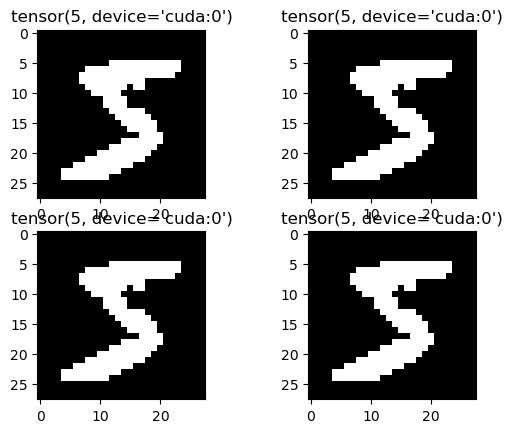

In [4]:
# Show 4 random images from the training dataset in grid
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        idx = torch.randint(0, len(train_dataset), (1,)).item()
        image = train_dataset[idx][0].squeeze().cpu()
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(train_dataset[idx][1])
plt.show()


In [8]:
# Hebbian Learning
torch.manual_seed(42)
random.seed(42)
model_name = "mnist_hopfield_hebbian"
size = 1
for dim in INPUT_SHAPE:
    size *= dim

energy_fn = ErrorEnergy()
# energy_fn = LyapunovEnergy()
# actv_fn = StochasticHopfieldActivation(temperature=0.0)
actv_fn = FastHopfieldActivation(prefer=-1)
model = HopfieldNet(size, energy_fn, actv_fn, bias=True, init_weights=True, steps=1).to(device)
step = 0

In [9]:
model = model.to(device)
LR = 3e-4
BATCH_SIZE=1 # 8000 * DATA_RATIO seems effective
epochs = 1000
criterion = nn.MSELoss()
optimiser = optim.AdamW(model.parameters(), lr=LR, betas=(0.0, 0.0)) # I think momentum is bad but weight decay is good
scheduler = ReduceLROnPlateau(optimiser, mode='min', min_lr=3e-8, factor=0.75, patience=100, verbose=True)
energy, loss, step = train_reconstruct(model, 
                             train_dataset, 
                             optimiser, 
                             model_name, 
                             epochs, 
                            #  scheduler, 
                             flatten=True, 
                             step=step, 
                             batch_size=BATCH_SIZE, 
                             mode="energy",
                            #  untrain_after=1,
                             untrain_const=0.001,
                             validate_every=10,
                             device=device)
print(f"Final energy: {energy[-1]} - Final loss: {loss[-1]}")

Final energy: 914.679443359375 - Final loss: 3.165816307067871


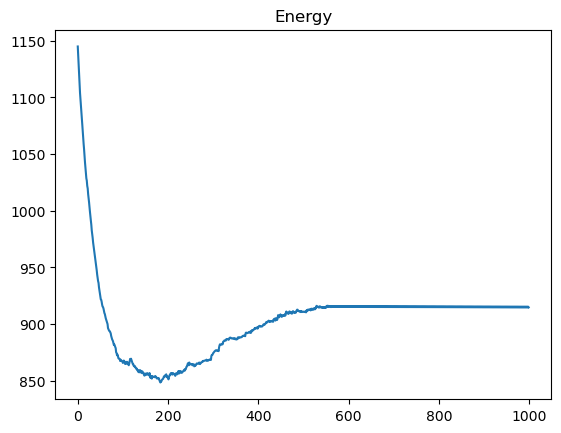

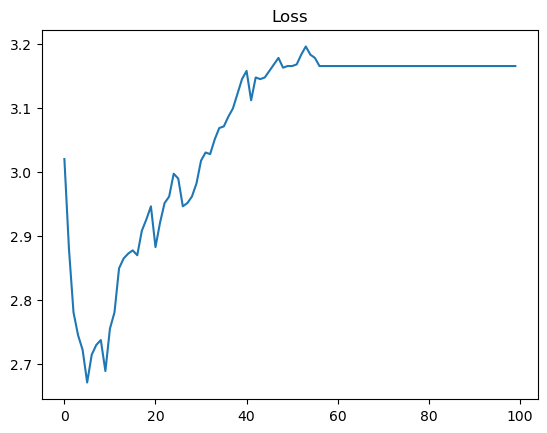

In [10]:
# plot energy
plt.plot(energy)
plt.title("Energy")
plt.show()

# plot loss
plt.plot(loss)
plt.title("Loss")
plt.show()

In [12]:
x = torch.rand(1, 784).to(devicejj)
y = model(x)
y.shape

torch.Size([1, 784])

In [27]:
image = torch.rand(64)
weight = torch.rand(64, 64, requires_grad=True)
optimiser = optim.SGD([weight], lr=0.1)

In [28]:
for _ in range(11):
    out = image @ weight
    err = (out - image).abs().mean()
    print(f'{err}')

    optimiser.zero_grad()
    err.backward()
    optimiser.step()

17.53016471862793
17.490720748901367
17.451274871826172
17.41183090209961
17.372385025024414
17.332942962646484
17.293498992919922
17.254053115844727
17.214609146118164
17.1751651763916
17.13572120666504


c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


IndexError: list index out of range

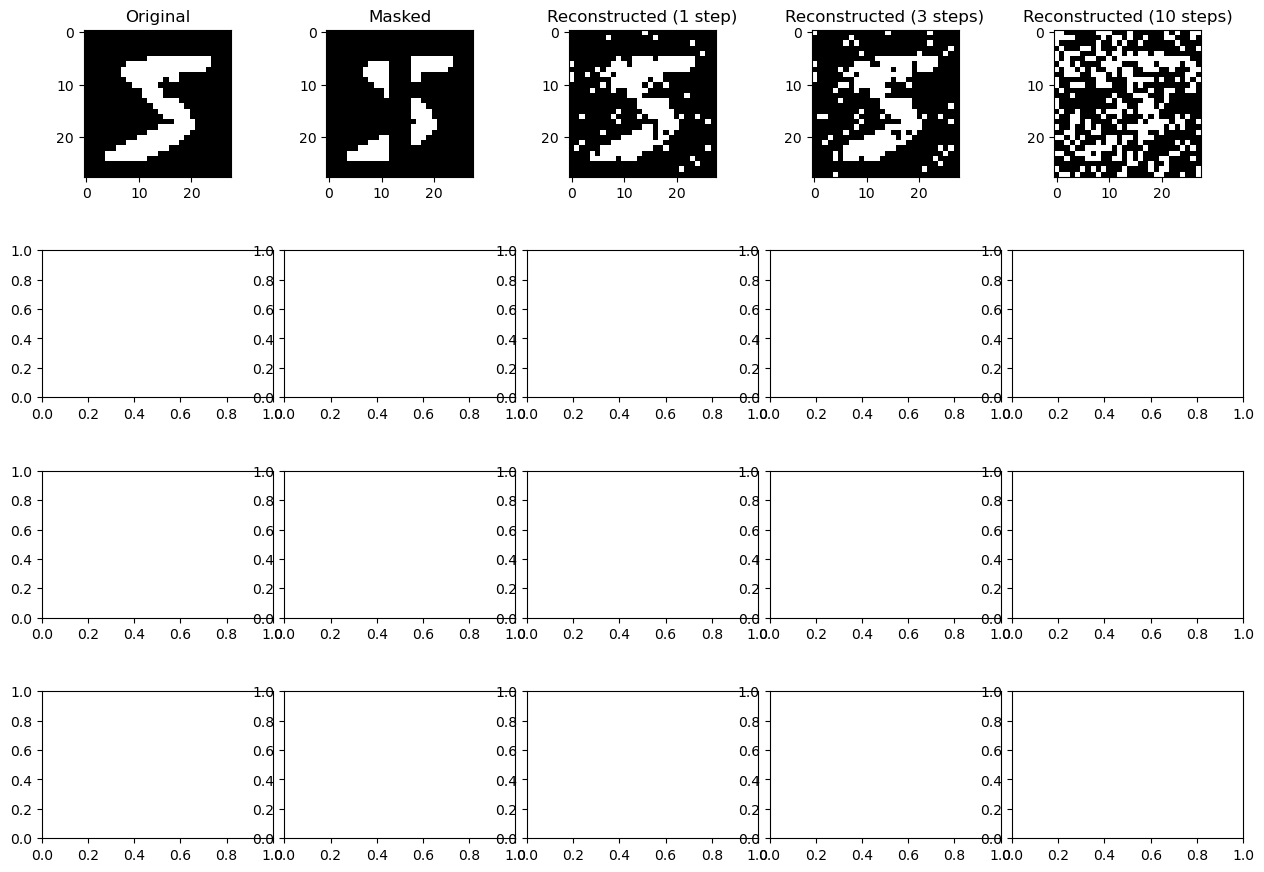

In [29]:
# Show 4 examples of original, masked and reconstructed images, with extra spacing between subplots
steps = (1, 3, 10)
width = 0.2
length = 4
if len(train_dataset) < 4:
    length = len(train_dataset)

# Randomly select 4 images from the training dataset
idxs = []
while len(idxs) < length:
    idx = torch.randint(0, len(train_dataset), (1,)).item()
    if idx not in idxs:
        idxs.append(idx)

fig, ax = plt.subplots(4, 5)
for i in range(4):
    original = train_dataset[idxs[i]][0].squeeze()
    if i < 2:
        masked = mask_center_column(original, width)
    else:
        masked = mask_center_row(original, width)
    masked = torch.tensor(masked)
    reconstructed_1 = model(masked.view(-1), steps=steps[0]).view(INPUT_SHAPE)
    reconstructed_2 = model(masked.view(-1), steps=steps[1]).view(INPUT_SHAPE)
    reconstructed_3 = model(masked.view(-1), steps=steps[2]).view(INPUT_SHAPE)
    ax[i, 0].imshow(original.cpu(), cmap="gray")
    ax[i, 1].imshow(masked.cpu(), cmap="gray")
    ax[i, 2].imshow(reconstructed_1.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 3].imshow(reconstructed_2.detach().squeeze(0).cpu(), cmap="gray")
    ax[i, 4].imshow(reconstructed_3.detach().squeeze(0).cpu(), cmap="gray")
    if i == 0:
        ax[i, 0].set_title("Original")
        ax[i, 1].set_title("Masked")
        ax[i, 2].set_title(f"Reconstructed ({steps[0]} step)")
        ax[i, 3].set_title(f"Reconstructed ({steps[1]} steps)")
        ax[i, 4].set_title(f"Reconstructed ({steps[2]} steps)")
    # Add extra spacing between subplots
    # Make images bigger
    fig.set_size_inches(15.5, 10.5)
    plt.subplots_adjust(wspace=0.05, hspace=0.5)


plt.show()

